In [1]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [2]:
data_dir = Path("/media/wwymak/Storage") / "imagenette-dali"

untar_data(URLs.IMAGENETTE_160, dest=data_dir)
(data_dir / "imagenette-160").ls()

[PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/models'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/valid')]

In [3]:
(data_dir / "imagenette-160"/"train").ls()

[PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03417042'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03394916'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n02979186'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n01440764'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03425413'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03445777'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n02102040'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03028079'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03000684'),
 PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03888257')]

In [5]:
(data_dir / "imagenette-160"/"train"/"n03417042").ls()[0]

PosixPath('/media/wwymak/Storage/imagenette-dali/imagenette-160/train/n03417042/n03417042_7668.JPEG')

In [4]:
src = (ImageList.from_folder(data_dir / "imagenette-160")
                  .split_by_folder()              
                    .label_from_folder() )
size=160
batch_size=64
tfms = get_transforms()
data = (src
        .transform(tfms, size=size)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

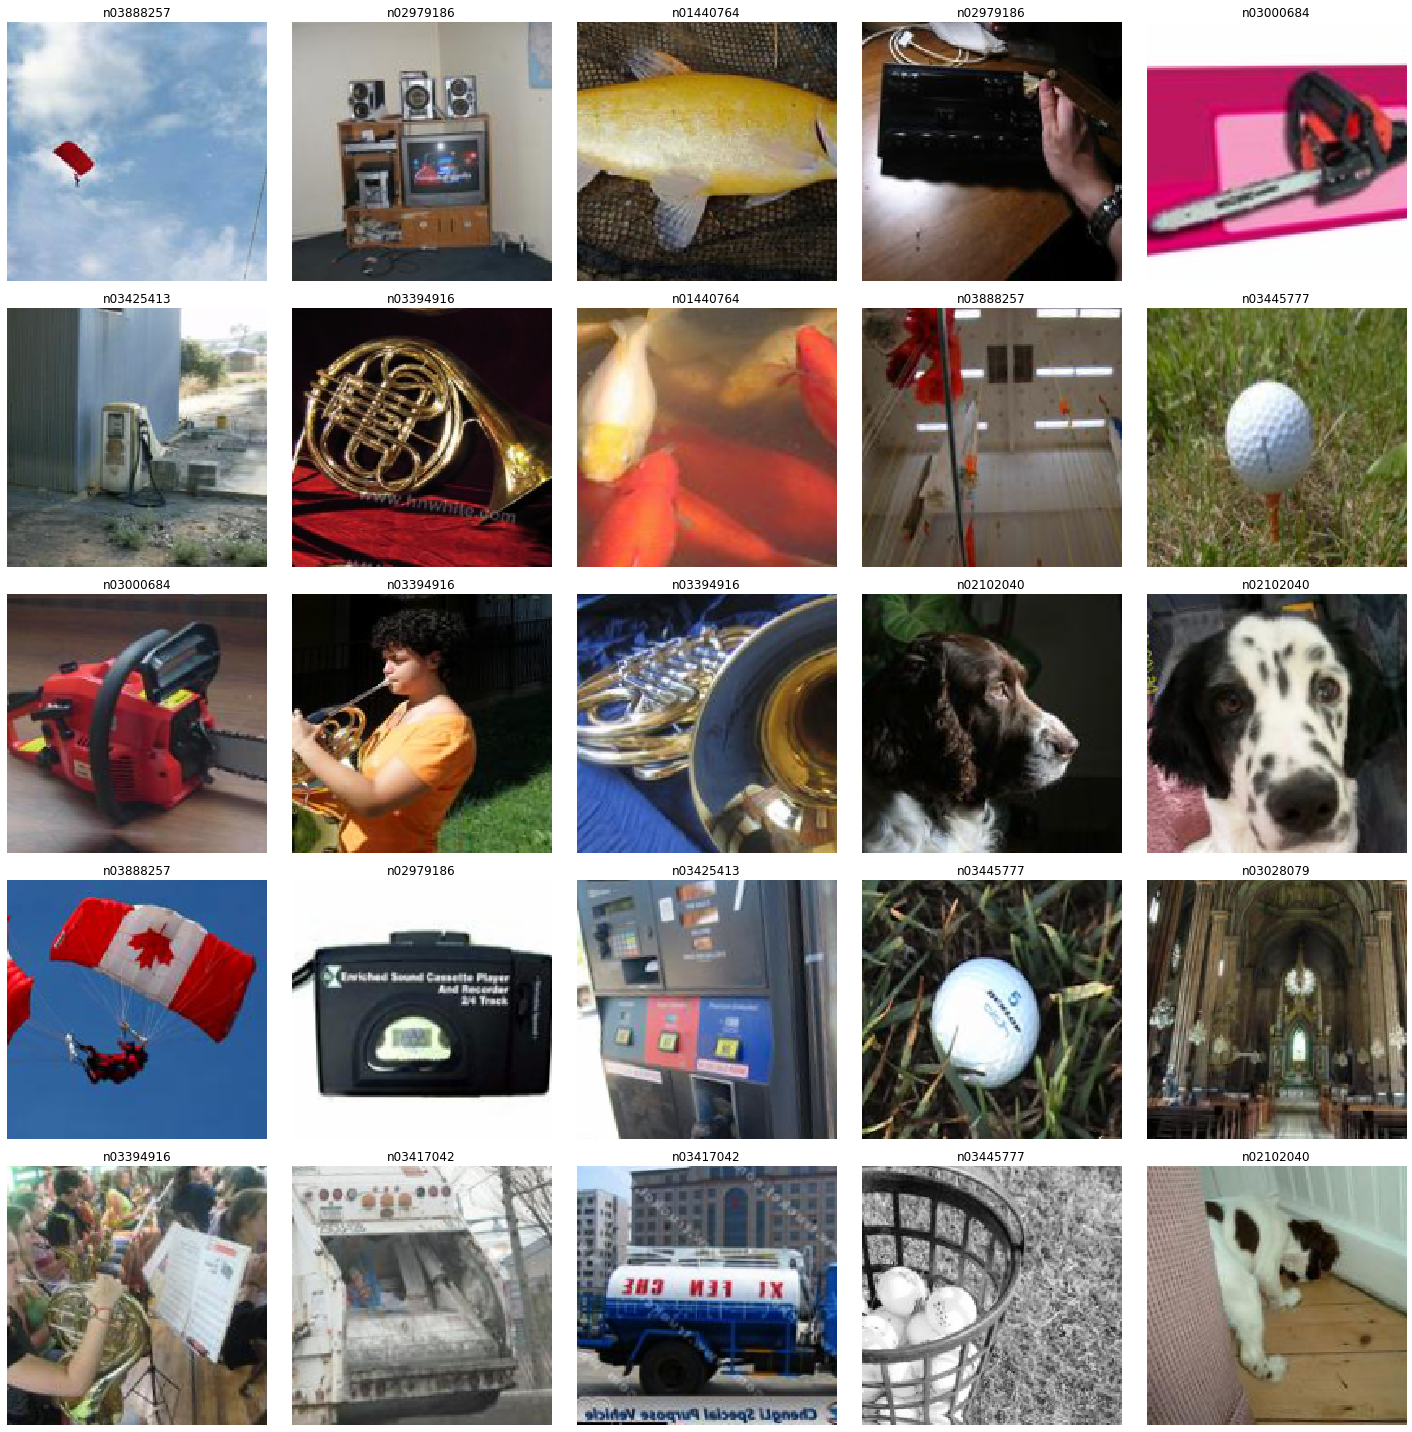

In [5]:
data.show_batch()

#### Evolving cell to contain the most current iteration of my implementation of hrnet

In [108]:
BN_MOMENTUM = 0.1


def conv_bn_relu(ni, nf, ks = 3, stride= 1):
    "Create a seuence Conv2d->BatchNorm2d->LeakyReLu layer."
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks // 2),
        nn.BatchNorm2d(nf, momentum=BN_MOMENTUM),
        nn.ReLU(inplace=True))


def conv_bn(ni, nf, ks = 3, stride= 1) -> nn.Sequential:
    "Create a seuence Conv2d->BatchNorm2d-"
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks // 2),
        nn.BatchNorm2d(nf, momentum=BN_MOMENTUM))


def init_cnn(m):
    if getattr(m, 'bias', None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    for l in m.children(): init_cnn(l)


def make_layer(block, inplanes, planes, blocks, stride=1):
    """
    create a layer group of block with blocks repeats
    :param block: nn.Module e.g. resnet block etc
    :param inplanes: int num input filter into the layer
    :param planes: int num output filters from the layer
    :param blocks: int number of blocks in layer
    :param stride: conv stride
    :return:
    """
    downsample = None

    if stride != 1 or inplanes != planes * block.expansion:
        downsample = conv_bn(inplanes, planes * block.expansion, ks=1, stride=stride)

    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    if blocks > 1:
        inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes, stride, downsample=None))
    return nn.Sequential(*layers)


class BasicBlock(Module):
    def __init__(self, ni: int, nout: int, downsample=None):
        self.downsample = downsample
        self.conv1 = conv_bn_relu(ni, nout, ks=3)
        self.conv2 = conv_bn(nout, nout, ks=3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv_out = nn.Sequential(
            self.conv1,
            self.conv2)
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(x + conv_out(x))


class Stem(Module):
    def __init__(self):
        self.conv1 = conv_bn_relu(ni=3, nf=64, ks=3, stride=2)
        self.conv2 = conv_bn_relu(ni=64, nf=64, ks=3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ResidualBlock(Module):
    expansion = 4
    """
    Core res unit (bottleneck version)
    according to the hrnet paper:
    > The 1st stage contains 4 residual units
    > where each unit is formed by a bottleneck with the width 64,
    > and is followed by one 3×3 convolution reducing the width
    > of feature maps to C
    """

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        self.downsample = downsample
        self.conv1 = conv_bn_relu(inplanes, planes, ks=1)
        self.conv2 = conv_bn_relu(planes, planes, ks=3)
        self.conv3 = conv_bn(planes, planes * self.expansion, ks=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        conv_out = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3)
        out = conv_out(x)
        out += identity
        return self.relu(out)


class MultiResBlock(Module):
    def __init__(self, n_branches, n_branches_out, block, num_blocks, n_channels_in, num_channels, n_channels_out):
        self.n_branches = n_branches
        self.n_branches_out = n_branches_out
        self.num_blocks = num_blocks
        self.num_channels = num_channels
        self.n_channels_in = n_channels_in
#         self.relu = nn.ReLU(inplace=True)
        self.relu = nn.ReLU(inplace=False)
        self.block = block
        self.n_channels_out = n_channels_out
        
        self.branches = self._make_branches()
        self.exchange_unit = self._make_exchange_unit()

        assert len(num_blocks) == len(num_channels) == len(n_channels_in)

    def forward(self, x):
        # group convolutions
        x = [branch(xi) for (branch, xi) in zip(self.branches, x)]
        # transition unit
        output = []
        for idx, unit in enumerate(self.exchange_unit):
            xi = x[idx]
            for j in range(len(self.branches)):
                intermediate_res = unit[j](xi)
                if j >= idx:
                    xi = xi + intermediate_res
                else:
                    upsampled = F.interpolate(intermediate_res,
                                              size=xi.shape[:-2],
                                              mode='bilinear')
                    xi = xi+ upsampled

                output.append(xi)

        return output

    def _make_branches(self):
        branches = []
        for i in range(self.n_branches):
            inplanes = self.n_channels_in[i]
            planes = self.num_channels[i]
            print(i, inplanes, planes)
            branch = make_layer(self.block, inplanes, planes, blocks=self.num_blocks[i])
            branches.append(branch)

        return  nn.ModuleList(branches)

    def _make_exchange_unit(self):
        n_branches_out = self.n_branches_out
        exchange_layers = []
        for i in range(n_branches_out):
            layer_stack = []
            for j in range(self.n_branches):
                # resolution_factor = (i - j) * 2
                # ks=3 for downsampling, or a 1 x1 conv otherwise (and use interpolation later to upsample)
                # ks = 3 if resolution_factor > 0 else 1
                # stride = max(1, resolution_factor)
                planes = self.n_channels_out[i]
                inplanes = self.num_channels[j]
                if i == j:
                    layer_stack.append(nn.Identity())
                elif j > i:
                    # it's on a branch with a smaller resolution, need to upsample later

                    stride = 1
                    ks = 1
                    layer_stack.append(conv_bn(ni=inplanes, nf=planes, ks=ks, stride=stride))
                else:
                    ks = 3
                    stride = 2
                    # if j > i, then we need to downsample, which is done via a series of stride 2 3x3 convolutions
                    downsample_convs = [conv_bn_relu(ni=inplanes, nf=planes, ks=ks, stride=stride) for _ in range(i - j -1)]
                    downsample_convs.append(conv_bn(ni=inplanes, nf=planes, ks=ks, stride=stride))
                    layer_stack.append(nn.Sequential(*downsample_convs))

            exchange_layers.append(nn.ModuleList(layer_stack))

        return nn.ModuleList(exchange_layers)


class HRNet(Module):
    def __init__(self):
        self.stem = Stem()
        n_channels = [64,128, 256, 512]
#         self.stage1 = self._make_layer(ResidualBlock, 64, 64, blocks=4)
        self.stage1 = self._make_stage(num_modules=1, num_branches=1, num_branches_out=2, num_blocks=[4], 
                                       num_channels=n_channels[:1],n_channels_in=[64], 
                                       n_channels_out = [x * 4 for x in n_channels[:2]])

        self.stage2 = self._make_stage(num_modules=1, num_branches=2, num_branches_out=3, num_blocks=[4,4], 
                                       num_channels=n_channels[:2], 
                                       n_channels_out = [x * 4 for x in n_channels[:3]],
                                       n_channels_in=n_channels[:2])
#         self.stage3 = self._make_stage(num_modules=1, num_branches=3, num_branches_out=4, num_blocks=[4,4,4], num_channels=[32, 64, 128],
#                                        n_channels_in=[x * 4 for x in [32,64]])
#         self.stage4 = self._make_stage(num_modules=1, num_branches=4, num_branches_out=4, num_blocks=[4,4,4,4], num_channels=[32, 64, 128, 256],
#                                        n_channels_in=[x * 4 for x in [32, 64, 128]])


        init_cnn(self)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        """
        create a layer group of block with blocks repeats
        :param block: nn.Module e.g. resnet block etc
        :param inplanes: int num input filter into the layer
        :param planes: int num output filters from the layer
        :param blocks: int number of blocks in layer
        :param stride: conv stride
        :return:
        """
        downsample = None

        if stride != 1 or inplanes != planes * block.expansion:
            downsample = conv_bn(inplanes, planes * block.expansion, ks=1, stride=stride)

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes, stride, downsample=None))
        return nn.Sequential(*layers)

    def _make_stage(self, num_modules, num_branches, num_branches_out, num_blocks, num_channels, n_channels_in, n_channels_out):
        layers = [MultiResBlock(num_branches, num_branches_out, ResidualBlock, num_blocks, n_channels_in, num_channels, n_channels_out) for
                  _ in range(num_modules )]
#         layers.append(MultiResBlock(num_branches, num_branches_out, ResidualBlock, num_blocks, n_channels_in, num_channels, n_channels_out))
        return nn.Sequential(*layers)

    def _multires_to_single(self, x):
        highest_res_layer = x[0]
        final_concat_layers = [highest_res_layer]
        for i in range(1, len(x)):
            xi = F.upsample(x[i], size=highest_res_layer.size()[-2:], mode='bilinear')
            final_concat_layers.append(xi)

        return torch.cat(final_concat_layers, dim=1)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1([x]) # this is now a list
        print('stage1', len(x), x[0].shape)
        x = self.stage2(x)
        #         x = self.stage3(x)
        #         x = self.stage4(x)
        x = self._multires_to_single(x)
        print(x.shape)
        return x

#### create baseline: resnet34

In [64]:
learn = cnn_learner(data,models.resnet34, pretrained=False, metrics=[accuracy])
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.865336,4.204257,0.340000,00:17
1,1.724531,6.179035,0.356000,00:17
2,1.659044,1.494275,0.494000,00:17
3,1.323281,1.966247,0.486000,00:17
4,1.116580,0.942718,0.692000,00:17
5,0.997515,0.864559,0.720000,00:17
6,0.853031,0.684281,0.780000,00:17
7,0.727719,0.544551,0.824000,00:18
8,0.621527,0.500909,0.848000,00:17
9,0.576160,0.486390,0.858000,00:17


#### Test the stem:

In [26]:
def custom_model(pretrained=False):
     return nn.Sequential(
        Stem(),
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Linear(in_features=256, out_features=10, bias=True)
    )
learn = cnn_learner(data,custom_model, pretrained=False, metrics=[accuracy])

In [27]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 80, 80]         1,728      True      
______________________________________________________________________
BatchNorm2d          [64, 80, 80]         128        True      
______________________________________________________________________
ReLU                 [64, 80, 80]         0          False     
______________________________________________________________________
Conv2d               [64, 40, 40]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 40, 40]         128        True      
______________________________________________________________________
ReLU                 [64, 40, 40]         0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [64, 1, 1]           0          False     
___________________________________________________

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


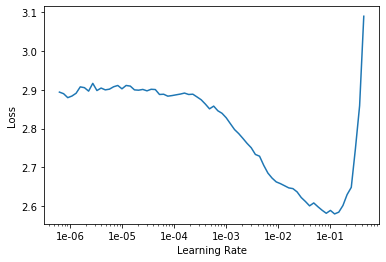

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.828797,1.399011,0.550000,00:07
1,1.545122,1.379659,0.536000,00:07
2,1.434198,1.213837,0.598000,00:07
3,1.325436,1.312222,0.584000,00:07
4,1.219242,1.045785,0.670000,00:07
5,1.175056,0.978004,0.682000,00:07
6,1.080256,0.863249,0.734000,00:07
7,1.031119,0.783109,0.742000,00:07
8,0.979613,0.769883,0.752000,00:07
9,0.972449,0.795518,0.744000,00:07


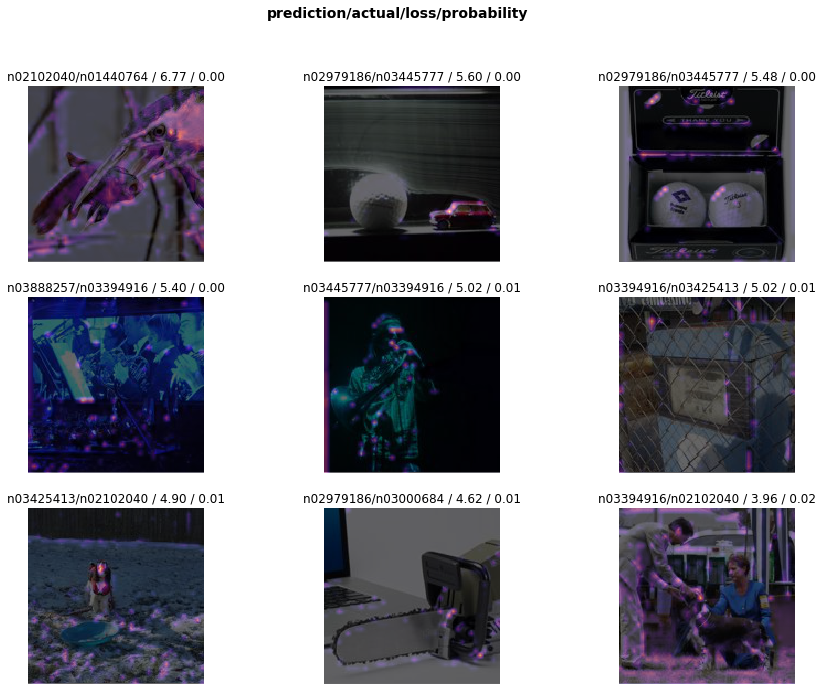

In [33]:
# a bit weird? are the images not denormed?
interpretation = ClassificationInterpretation.from_learner(learn)
losses, idxs = interpretation.top_losses()
interpretation.plot_top_losses(9, figsize=(15,11))

#### Test Stem + 1st layer

In [109]:
def custom_model(pretrained=False):
    model =  nn.Sequential(
        HRNet(),
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Linear(in_features=256, out_features=10, bias=True)
    )
    init_cnn(model)
    return model
learn = cnn_learner(data,custom_model, pretrained=False, metrics=[accuracy])

0 64 64
0 64 64
1 128 128


IndexError: list index out of range

In [80]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 80, 80]         1,728      True      
______________________________________________________________________
BatchNorm2d          [64, 80, 80]         128        True      
______________________________________________________________________
ReLU                 [64, 80, 80]         0          False     
______________________________________________________________________
Conv2d               [64, 40, 40]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 40, 40]         128        True      
______________________________________________________________________
ReLU                 [64, 40, 40]         0          False     
______________________________________________________________________
Conv2d               [256, 40, 40]        16,384     True      
___________________________________________________

In [94]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 80, 80]         1,728      True      
______________________________________________________________________
BatchNorm2d          [64, 80, 80]         128        True      
______________________________________________________________________
ReLU                 [64, 80, 80]         0          False     
______________________________________________________________________
Conv2d               [64, 40, 40]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 40, 40]         128        True      
______________________________________________________________________
ReLU                 [64, 40, 40]         0          False     
______________________________________________________________________
Conv2d               [256, 40, 40]        16,384     True      
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


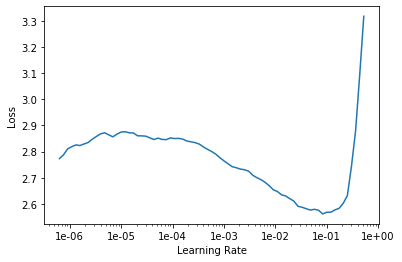

In [95]:
learn.lr_find()
learn.recorder.plot()

In [96]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.758711,2.108438,0.366000,00:13
1,1.406634,1.245792,0.568000,00:13
2,1.268503,1.306722,0.554000,00:13
3,1.154045,1.026267,0.686000,00:14
4,1.013312,0.818790,0.744000,00:13
5,0.914655,0.761359,0.766000,00:14
6,0.817747,0.636926,0.806000,00:14
7,0.736534,0.558281,0.824000,00:14
8,0.647003,0.470144,0.866000,00:14
9,0.641746,0.465987,0.866000,00:14


In [59]:
x = Tensor([1,2,3])
nn.Identity()(x)

tensor([1., 2., 3.])

In [60]:
a = nn.ModuleList([nn.Identity()])

In [61]:
a[0](x)

tensor([1., 2., 3.])